## #1. Create composite table for clustering

Import processed dataset

Pseudo-imputation:
- serological values -> add extra category: 'not measured' (e.g. 2)
- for SSA -> rule if SSA is missing -> you can infer that ENA is negative

#### Get eligible patients (identified RA-patients with a prob>=0.83)

In [3]:
import pandas as pd
df_pat = pd.read_csv(r'../filters/RA_patients_083_new.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.NEW_PEC))
len(new_pat)

1251

### #1.1 Import Lab

In [ ]:
import sys
sys.path.append(r'../src/1_emr_scripts')

import pandas as pd
import numpy as np

l_col = ['MCV', 'Leuko', 'MCH', 'Hb', 'Ht', 'MCHC', 'BSE', 'Trom' ,'prediction' , 'RF', 'aCCP', 'aSSA', 'ENA', 'ANA', 'patnr', 'time'] # 


df_imp = pd.read_csv(r'../data/4_processed/DF_Lab_formatted.csv', sep=',', index_col=0)

df_pat = pd.read_csv(r'../filters/RA_patients_083_new.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.NEW_PEC))

# Only include patients after August 2011
df_imp = df_imp[df_imp['patnr'].isin(df_pat['PATNR'])]
df_imp['prediction'] = df_imp.apply(lambda x: df_pat[df_pat['PATNR']==x['patnr']]['prediction'].iloc[0],axis=1) # add prediction

l_lab = [x for x in list(df_imp.columns) if x not in ['patnr', 'time', 'prediction']] 

df_imp.head()

### #1.2 Import Age & Sex

In [ ]:
from datetime import datetime, date

def age(row): 
    """
    Calculate the age of the patient
    
    Input:
        row = entry of patient
    Output:
        age = age of paitient
    """
    born = row['birthDate']
    pec = row['PEC']
    pec = datetime.strptime(pec[:19], "%Y-%m-%d %H:%M:%S").date()
    born = datetime.strptime(born[:19], "%Y-%m-%d %H:%M:%S").date()
    #today = date.today()
    return pec.year - born.year - ((pec.month, 
                                      pec.day) < (born.month, 
                                                    born.day))
def binarize_sex(sex):
    """
    Cast string type values to binary (male= 0, female=1)
    """
    if sex == 'M':
        return 0
    else :
        return 1

df_ageSex = pd.read_csv(r'../data/1_raw/Clustering_Age_Sex.csv', sep=';')

# get actual patient ids - for linking data
df_keys = pd.read_csv(r'../data/1_raw/Pseudonymized_Keys.csv', sep=';')
d_translation = dict(zip(df_keys.member_entity_Pseudonym_value, df_keys.member_entity_Patient_value))
df_ageSex['patnr'] = df_ageSex['identifier_value'].apply(lambda x: d_translation[x])

# get date of first consult
df_pat = pd.read_csv(r'../filters/RA_patients_083.csv', sep=',', index_col=0)
new_pat = dict(zip(df_pat.PATNR, df_pat.PEC))
df_ageSex['PEC'] = df_ageSex['patnr'].apply(lambda x: new_pat[x])

# calculate age from day of birth
df_ageSex['Age'] = df_ageSex.apply(lambda x: age(x), axis= 1)
df_ageSex['Sex'] = df_ageSex['gender_code_original'].apply(lambda x: binarize_sex(x))

# add age & sex to lab values
df_imp = df_imp.merge(df_ageSex[['Age', 'Sex', 'patnr']], on='patnr')

l_demographic = ['Age', 'Sex']

df_imp.head() 

### #1.3 Import Mannequin data

In [ ]:
df_man = pd.read_csv(r'../data/4_processed/DF_Mannequin_Engineered.csv', sep='|')
df_man = df_man.rename(columns={"PATNR" : "patnr"})

l_mannequin = [x for x in list(df_man.columns) if x not in ['patnr']] 

#df_man.head()
df_imp = df_imp.merge(df_man, on="patnr")
df_imp.head()

### [UNUSED] #1.4 Import text data 
- Physician's notes
- Radiographic notes

In [ ]:
## Add Physician bigrams
df_phy = pd.read_csv(r'../data/4_processed/DF_Physician_bigrams.csv', sep='|')
df_imp = df_imp.merge(df_phy, how='left',  on="patnr")

## Add Radiographic bigrams
#df_rad = pd.read_csv(r'../data/4_processed/DF_Radiographic_bigrams.csv', sep='|')
#df_imp = df_imp.merge(df_rad, how='left', on="patnr")
#df_imp.fillna(' ')

l_physician = [x for x in list(df_phy.columns) if x not in ['patnr']] 
#l_radiographic = [x for x in list(df_rad.columns) if x not in ['patnr']]
df_imp.head()

### #1.5 Import Physician information

In [29]:
# get PHYSICIAN
df_phys = pd.read_csv(r'../data/4_processed/DF_Treating_Physician_Information.csv', sep='|')

d_phys = dict(zip(df_phys.PATNR, df_phys.PHYSICIAN))
df_imp['PHYSICIAN'] = df_phys['PATNR'].apply(lambda x: d_phys[x])

#### Check overlap old & new extraction

In [19]:
df_keys = pd.read_csv(r'../data/1_raw/Pseudonymized_Keys.csv', sep=';')
df_pat = pd.read_csv(r'../filters/RA_patients_083.csv', sep=',', index_col=0)

l_missing = list(set(df_pat['PATNR']) - set(df_keys['member_entity_Patient_value']))

#### Save HIX IDS seperately

In [73]:
df_extra_inf = df_imp[['patnr', 'prediction']].copy()
df_extra_inf = df_extra_inf.reset_index()
df_extra_inf = df_extra_inf.rename(columns={'index' : 'sample'})
df_extra_inf.to_csv('../data/6_clustering/df_HIX_PATNR.csv', index=False)

## #2 Processing Mixed Type of Data


### #2.1 Distinguish between categorical and numerical data [Only for Visualization]

- Also distinguish between requested variables (like RF/ aCCP) and unique variables (like swollen knee joint R)

In [34]:
# Representation purposes

# Text
l_text = l_physician.copy() 
#l_text.extend(l_radiographic)

# Categorical
l_cat = ['RF', 'aCCP', 'aSSA', 'ENA', 'ANA', 'Sex']

# Continuous
l_con = ['Leuko', 'MCH', 'Hb', 'Ht', 'MCHC']

# Counts
l_count = ['MCV', 'BSE', 'Trom' , 'Age', 'Big joints', 'Small joints', 'Symmetrical joints', 'SJC', 'TJC']

# Visualization purposes
l_request = ['MCV', 'Leuko', 'MCH', 'Hb', 'Ht', 'MCHC', 'BSE','Trom', 
             'RF', 'aCCP', 'aSSA', 'ENA', 'ANA', 'Age', 'Sex', 'Big joints', 
             'Small joints', 'Symmetrical joints', 'SJC', 'TJC']
l_remove = l_request.copy()
l_remove.extend(['patnr', 'time', 'prediction'])

l_remove.extend(l_text) ## Remove if you exclude text

l_unique = [x for x in list(df_imp.columns) if x not in l_remove] # ignore id and time

l_cat.extend(l_unique)

# Numerical
l_num = l_con.copy()
l_num.extend(l_count)
l_num.extend(l_text)

l_all = l_num.copy()
l_all.extend(l_cat)

#### Save different components independently

In [42]:
df_imp[l_cat].to_csv('../data/6_clustering/df_all_categorical.csv', index=False, sep=',')

# get PHYSICIAN
df_phys = pd.read_csv(r'../data/4_processed/DF_Treating_Physician_Information.csv', sep='|')
#l_all_num.append('PHYSICIAN')

d_phys = dict(zip(df_phys.PATNR, df_phys.PHYSICIAN))
df_imp['PHYSICIAN'] = df_phys['PATNR'].apply(lambda x: d_phys[x])
df_imp[l_all_num].to_csv('../data/6_clustering/df_all_numerical.csv', index=False, sep=',')
#df_imp[l_text].to_csv('../data/6_clustering/df_tfidf.csv', index=False, sep=',')
#df_imp.to_csv('../data/6_clustering/df_complete.csv', index=False, sep=',')

In [37]:
df_imp[l_con].to_csv('../data/6_clustering/df_continuous.csv', index=False, sep=',')
df_imp[l_count].to_csv('../data/6_clustering/df_counts.csv', index=False, sep=',')
#df_imp[l_physician].to_csv('../data/6_clustering/df_tfidf_rheum.csv', index=False, sep=',')
#df_imp[l_radiographic].to_csv('../data/6_clustering/df_tfidf_radio.csv', index=False, sep=',')

d_cat = {0: 'negative', 1: 'positive', 2: 'absent'}
# df_imp[l_cat].apply(lambda x : [d_cat[i] for i in x])
df_imp[l_cat].to_csv('../data/6_clustering/df_categorical.csv', index=False, sep=',')

### #2.2 Preprocess the different layers 

In [60]:
import gower
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

SCALING = False

# Continuous
l_con = ['Leuko', 'MCH', 'Hb', 'Ht', 'MCHC']
# Counts
l_count = ['MCV', 'BSE', 'Trom' , 'Age', 'Big joints', 'Small joints', 'Symmetrical joints', 'SJC', 'TJC']
# Numerical
l_all_num = l_con.copy()
l_all_num.extend(l_count)

# Add text to numerical
#l_all_num.extend(l_physician)
#l_all_num.extend(l_radiographic)

# Remainder will become categorical
l_all_cat = [col for col in list(df_imp.columns) if col not in l_all_num]
l_all_cat = [col for col in l_all_cat if col not in ['patnr', 'time', 'prediction', 'PHYSICIAN']]

def fittingForClustering(df, l_all_num, l_all_cat, columns, z_score=True, fit_gaussian=False):
    """
    Input: 
        df = complete dataframe
        l_all_num = names of numerical columns
        l_all_cat = names of categorical columns
        colums = all column names
        z_score = whether or not to perform z-normalization
        fit_guassian = whether or not to apply a powertransformer
    
    Description:
        This function assigns each EHR-layer to a designated preprocessing 
        procedure. Categorical data is subjected to a one-hot-encoding
        whereas a z-score normalization is applied on the numerical data.
        
        Furthermore, the ESR (or BSE in dutch) is subjected to a 
        log-transformation.
    
    Output:
        df_dummies = dataframe with preprocessed categorical data 
        df_b = dataframe with preprocessed numerical data
    """

    l_num = [col for col in list(columns) if col in l_all_num]
    l_cat = [col for col in list(columns) if col in l_all_cat]
    
    # Split data    
    df_b = df[l_num].copy()
    if 'BSE' in columns:
        df_b['BSE'] = np.log(df_b['BSE'])
    matrix = df[l_cat].copy()

    # Numerical preprocessing
    if fit_gaussian:
        for c in df_b.columns:
            pt = PowerTransformer()
            df_b.loc[:, c] = pt.fit_transform(np.array(df_b[c]).reshape(-1, 1))
        ct = ColumnTransformer([("num", MinMaxScaler(), l_num)], remainder="passthrough")
        df_b = pd.DataFrame(ct.fit_transform(df_b[l_num]), columns=l_num)
    
    if z_score:
        ct = ColumnTransformer([("num", StandardScaler(), l_num)], remainder="passthrough")
        df_b = pd.DataFrame(ct.fit_transform(df_b[l_num]), columns=l_num)

    def cast_to_one_hot(values):
        # integer encode

        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values)
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        if len(np.unique(values)) == 3:
            df = pd.DataFrame(onehot_encoded, columns=[0, 1,2])
            df.index = np.arange(0, len(df))  
            return df[0], df[1], df[2] 
        elif len(np.unique(values)) == 2:
            df = pd.DataFrame(onehot_encoded, columns=[0, 1])
            df.index = np.arange(0, len(df))  
            return df[0], df[1], None  
        elif len(np.unique(values)) < 2:
            return None, None, None  

    def cast_to_str(x):
        d = {1: 'positive', 0:'negative', 2: 'missing'}
        return d[x]


    SETTING = 0

    # Categorical preprocessing
    if l_cat != []:
        for cat in l_cat:
            if SETTING==0: # one hot encoding
                matrix['%s_negative' % (cat)], matrix['%s_positive' % (cat)], matrix['%s_missing' % (cat)] = cast_to_one_hot(matrix[cat].values)
                #print(matrix[cat + '_negative' ])
                if len(matrix[matrix[cat + '_negative' ].isna()])>1: # remove if column doesnt hold any information:
                    matrix = matrix.drop(columns=['%s_negative' % (cat), '%s_positive' % (cat), '%s_missing' % (cat)])
                    print("Column %s doesn't hold any information and is therefore removed" % (cat))
                matrix = matrix.drop(columns=cat)

            elif SETTING==1: # casting to string
                matrix[cat] = matrix[cat].apply(lambda x : cast_to_str(x)) 
        matrix = matrix.reset_index(drop=True)
        df_dummies = matrix.copy()
        df_dummies = df_dummies.dropna(axis=1, how='all')
        
        if l_num != []:
            return df_b, df_dummies
        else :
            return None, df_dummies
    else :
        return df_b, None

l_all = l_all_num.copy()    
l_all.extend(l_all_cat)

df_b, df_dummies = fittingForClustering(df_imp, l_all_num, l_all_cat, columns=l_all) # l_all

## Gower distance
#matrix = gower.gower_matrix(matrix)

Column Zwelling_diffuus doesn't hold any information and is therefore removed
Column Zwelling_kaakrand palpabel doesn't hold any information and is therefore removed
Column Zwelling_pijnlijk bij palpatie doesn't hold any information and is therefore removed
Column Zwelling_vast-elastisch doesn't hold any information and is therefore removed


### #2.3 Save the processed EHR-layers

In [63]:
# Save Mannequin modalities
df_b, df_dummies = fittingForClustering(df_imp[l_mannequin], l_all_num, l_all_cat, columns=l_mannequin)
df_dummies.to_csv('../data/6_clustering/df_mannequin_categorical_ohe.csv', index=False, sep=',')
df_b.to_csv('../data/6_clustering/df_mannequin_counts_normalized_scaling.csv', index=False, sep=',')


# Save LAB modalities
df_b, df_dummies = fittingForClustering(df_imp[l_lab], l_all_num, l_all_cat, columns=l_lab)
df_dummies.to_csv('../data/6_clustering/df_lab_serology.csv', index=False, sep=',')
df_b.to_csv('../data/6_clustering/df_lab_numerical.csv', index=False, sep=',')

Column Zwelling_diffuus doesn't hold any information and is therefore removed
Column Zwelling_kaakrand palpabel doesn't hold any information and is therefore removed
Column Zwelling_pijnlijk bij palpatie doesn't hold any information and is therefore removed
Column Zwelling_vast-elastisch doesn't hold any information and is therefore removed


# #3. Unused work

### [UNUSED] Downcast high-dimensional data-modalities [optional]
- Motivation: you generally want each modality to have just as much influence
- Motivation #2: you want to convert binary to numeric data

### #3.1 Concatenate different UMAP embeddings
- Numerical: Bray curtis (as it is more adapted to the sparse data -> it is not affected by NULL-values like Euclidian)
- Categorical: jaccard -> simple union / total unique

In [16]:
import umap

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df_dummies.columns) / (len(df_b.columns) + len(df_dummies.columns))

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='braycurtis').fit(df_b.values) # euclidean braycurtis
fit2 = umap.UMAP(metric='jaccard').fit(df_dummies.values)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=0.5) #1-categorical_weight 
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                1.0, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, densmap= False, densmap_kwds={}, output_dens=False)
func.visualize_umap_bokeh(embedding[0], df_imp, l_special, l_binary=l_binary, patient_id='patnr', cluster_id='PhenoGraph_clusters', title='concat_embedding')

/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


### #3.2 Apply Parametric UMAP

In [113]:
from umap.parametric_umap import ParametricUMAP

# combine
df_all =  pd.merge(df_b, df_dummies, left_index=True, right_index=True)[:650]

embedder = ParametricUMAP(autoencoder_loss = True, metric='braycurtis') #ParametricUMAP(encoder=encoder, dims=dims)
fit1 = embedder.fit_transform(df_all.values) # df_emb.values
#fit2 = umap.UMAP(metric='jaccard').fit(df_dummies.values)

func.visualize_umap_bokeh(fit1, df_imp[:650], l_all, l_binary=l_binary, patient_id='patnr', cluster_id='PhenoGraph_clusters', title='raw_umap')

/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/umap/parametric_umap.py:269: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/10
21/21 [==============================] - 4s 149ms/step - loss: 0.7075
Epoch 2/10
21/21 [==============================] - 3s 150ms/step - loss: 0.5233
Epoch 3/10
21/21 [==============================] - 3s 148ms/step - loss: 0.4940
Epoch 4/10
21/21 [==============================] - 3s 148ms/step - loss: 0.4806
Epoch 5/10
21/21 [==============================] - 3s 151ms/step - loss: 0.4820
Epoch 6/10
21/21 [==============================] - 3s 148ms/step - loss: 0.4710
Epoch 7/10
21/21 [==============================] - 3s 148ms/step - loss: 0.4726
Epoch 8/10
21/21 [==============================] - 3s 148ms/step - loss: 0.4773
Epoch 9/10
21/21 [==============================] - 3s 150ms/step - loss: 0.4685
Epoch 10/10
21/21 [==============================] - 3s 147ms/step - loss: 0.4665


### #3.3 Employ Gower (Hybrid distance metric)

In [47]:
import umap
def infer_cat(val):
    d = {0 : 'negative', 1: 'positive', 2: 'missing'}
    return d[val]
matrix = df_b.merge(df_imp[l_cat], left_index=True, right_index=True)

for cat in l_cat:
    matrix[cat] = matrix[cat].apply(lambda x: infer_cat(x))
matrix = gower.gower_matrix(matrix)
fit1 = umap.UMAP(metric='euclidean').fit(matrix)
#fit1.embedding_
#matrix

In [84]:
silhouette_score(fit1, list(df_imp['PhenoGraph_clusters'].values))

0.6761797

### #3.4 Perform Hierarchical clustering on Raw data 

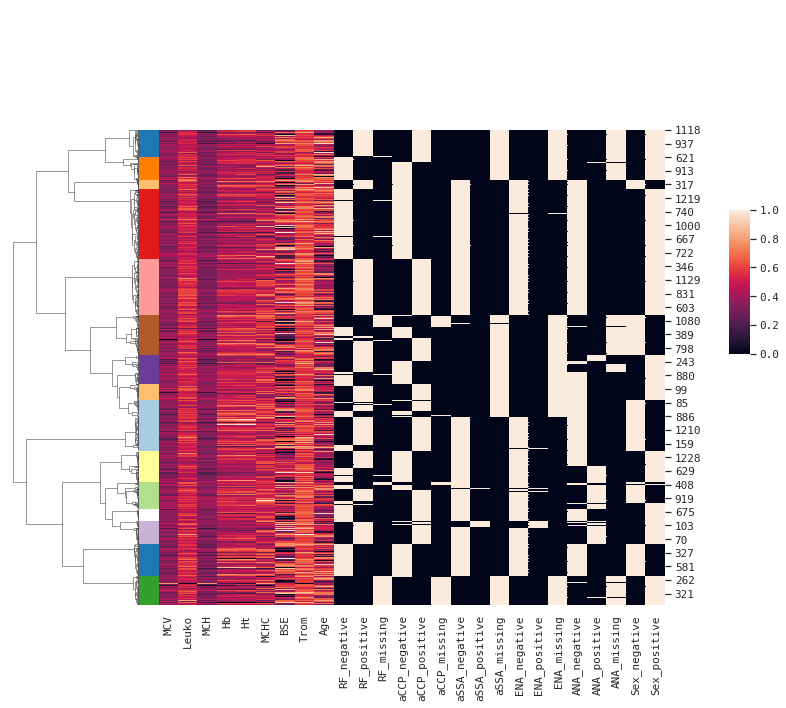

In [134]:
import pandas as pd, seaborn as sns

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
sns.set(font="monospace")

network_pal = sns.color_palette("Paired", 14)

lut = dict(zip(map(int, list(df_imp['PhenoGraph_clusters'].unique())), network_pal))
row_colors = pd.Series(df_imp['PhenoGraph_clusters'].tolist()).map(lut)

X, y = cluster_df.values, cluster_df.RF_positive
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = cluster_df.columns)

DF_dism = embedding[0]
linkage = hc.linkage(distance.pdist(DF_dism, 'euclidean'), method='average')
sns.clustermap(cluster_df, row_linkage=linkage, row_colors=row_colors, row_cluster=True, col_cluster=False, cbar_pos=(1.02, .5, .03, .2))

### #3.5 Correlation between variables

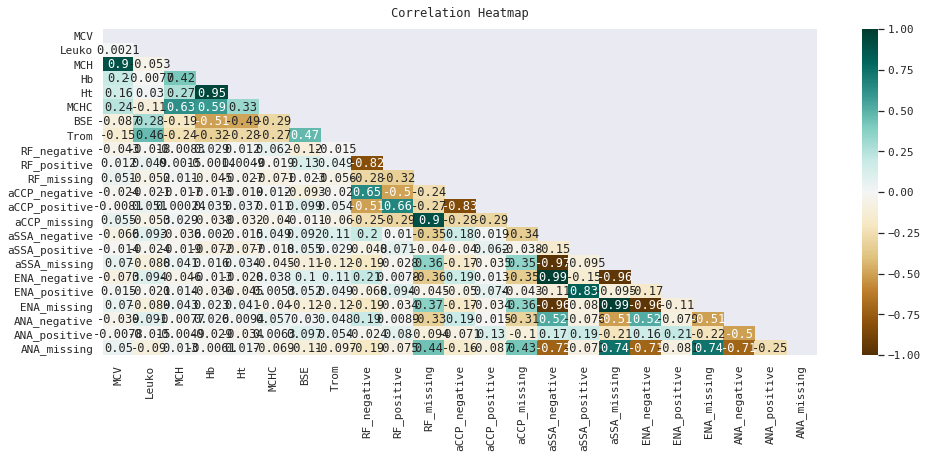

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(cluster_df.corr(), dtype=np.bool))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(cluster_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);